In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from matplotlib.patches import Patch

In [2]:
paths_to_folds_results = {
    "windowing": {
        "fold_0": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset515_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/summary.json",
        "fold_1": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset515_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation/summary.json",    
        "fold_2": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset515_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation/summary.json",
        "fold_3": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset515_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_3/validation/summary.json",
        "fold_4": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset515_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_4/validation/summary.json"
    },
    "windowing+nnUnetNorm": {
        "fold_0": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset516_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/summary.json",
        "fold_1": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset516_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation/summary.json",    
        "fold_2": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset516_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation/summary.json",
        "fold_3": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset516_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_3/validation/summary.json",
        "fold_4": "/media/robber/Nuevo vol/nnUNet/results/trained_models/Dataset516_HCUCH_Lesions/nnUNetTrainer__nnUNetPlans__2d/fold_4/validation/summary.json"
    }
}
paths_to_test_results = {
    "windowing": "/media/robber/Nuevo vol/nnUNet/results/inference/Dataset515_HCUCH_Lesions/2d/performance.csv",
    "windowing+nnUnetNorm": "/media/robber/Nuevo vol/nnUNet/results/inference/Dataset516_HCUCH_Lesions/2d/performance.csv"
}
path_to_series = "resources/metadata/series.json"
path_to_patients = "resources/metadata/patients.csv"
labels_mapping = {
    "1": "tumor",
    "2": "adenopathy"
}
save_results = True

In [3]:
with open(path_to_series, 'r') as file:
    series_df = pd.DataFrame(json.load(file))
patients_df = pd.read_csv(path_to_patients)

In [4]:
new_metrics_per_case = []
for normalization_scheme, results_dict in paths_to_folds_results.items():
    for fold, path in results_dict.items():
        with open(path, 'r') as file:
            results = json.load(file)
        new_metrics_per_case += [
            {
                "normalization": normalization_scheme,
                "fold": fold.split('_')[-1],
                "prediction_file": item["prediction_file"],
                "reference_file": item["reference_file"],
                "filename": Path(item["reference_file"]).name,
                "class_label": class_,
                "class_name": labels_mapping.get(class_),
                **metrics
            }
            for item in results['metric_per_case']
            for class_, metrics in item["metrics"].items()
        ]

In [5]:
new_metrics_per_case_df = pd.DataFrame(new_metrics_per_case)
# Add series and patient info
series_columns = ['uuid', 'patient_id', 'name', 'slice_thickness', 'row_spacing', 'column_spacing', 'slices', 'rows', 'columns']
patients_columns = ['patient_id', 'protocolo', 'sexo', 'edad', 'diagnóstico']
new_metrics_per_case_df['series_uuid'] = new_metrics_per_case_df['filename'].apply(lambda x: x.split('.nii.gz')[0])
new_metrics_per_case_df = new_metrics_per_case_df.merge(
    series_df[series_columns],
    left_on='series_uuid',
    right_on='uuid',
    how='left'
)
new_metrics_per_case_df = new_metrics_per_case_df.merge(
    patients_df[patients_columns],
    left_on='patient_id',
    right_on='patient_id',
    how='left'
)
if save_results:
    new_metrics_per_case_df.to_csv("metrics_per_case.csv", index=False)

# Desempeño en conjunto de Validación

## Desempeño medido sobre cada CT de Validación
- Se reporta el coeficiente Dice para cada CT de validación, obtenido con el modelo del fold correspondiente.
- Validación Cruzada 5 fold: cada CT es evaluado una sola vez en el conjunto de validación.
- Total de imágenes: 23 CTs (1 CT queda excluido al no tener anotaciones de tumor).
- Esta forma de medir el desempeño es susceptible a CTs mal segmentados, aun cuando el tamaño de la lesión es pequeño. El desempeño final medido cae drásticamente si existen CTs con coeficiente Dice cercano a 0. 

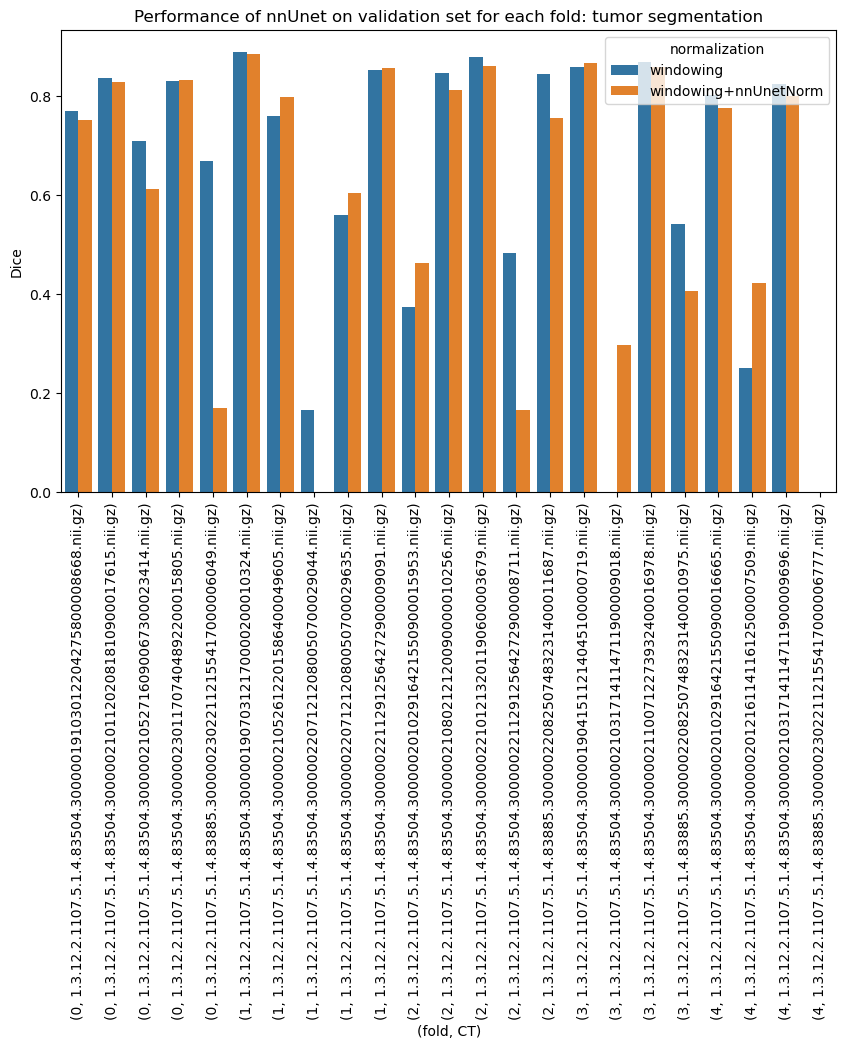

In [6]:
new_df_tumor = new_metrics_per_case_df[(new_metrics_per_case_df["class_name"] == "tumor") & (new_metrics_per_case_df["n_ref"] > 0) ].copy()
new_df_tumor['fold_filename'] = new_df_tumor.apply(lambda row: f"({row['fold']}, {row['filename']})", axis=1)
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df_tumor,
    x='fold_filename',
    y='Dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("(fold, CT)")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on validation set for each fold: tumor segmentation")
if save_results:
    plt.savefig('performance_validation_set_only_tumor.png', transparent=True, bbox_inches='tight')
plt.show()

In [7]:
grouped = new_metrics_per_case_df.groupby(["class_name", "fold", "normalization"])["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,class_name,fold,normalization,mean,std
0,tumor,0,windowing,0.762321,0.073883
1,tumor,0,windowing+nnUnetNorm,0.639008,0.277044
2,tumor,1,windowing,0.645006,0.296580
3,tumor,1,windowing+nnUnetNorm,0.628703,0.368135
4,tumor,2,windowing,0.685139,0.238177
5,tumor,2,windowing+nnUnetNorm,0.611515,0.293346
6,tumor,3,windowing,0.567073,0.407450
7,tumor,3,windowing+nnUnetNorm,0.607627,0.298527
8,tumor,4,windowing,0.469496,0.410128
9,tumor,4,windowing+nnUnetNorm,0.499394,0.375147


In [8]:
grouped = new_metrics_per_case_df.groupby(["class_name", "normalization"])["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,class_name,normalization,mean,std
0,tumor,windowing,0.635157,0.288050
1,tumor,windowing+nnUnetNorm,0.601053,0.296645


## Desempeño agregado sobre todos los CTs de Validación
- Se suman los TP, FP y FN de todas las series evaluadas, y con los valores acumulados se calcula el coeficiente de Dice.
- Esta modalidad de evaluación no penaliza CTs indivuales mal segmentados.

In [9]:
def get_aggregated_metrics(df):
    TP = df["TP"].sum()
    FP = df["FP"].sum()
    FN = df["FN"].sum()
    dice = 2*TP / (2*TP + FP + FN)
    metrics = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "dice": dice
    }
    return metrics

In [10]:
aggregated_metrics_df = []
for normalization, class_name in itertools.product(
    new_metrics_per_case_df["normalization"].unique().tolist(),
    new_metrics_per_case_df["class_name"].unique().tolist()
):
    agg_metrics = get_aggregated_metrics(
        new_metrics_per_case_df[
            (new_metrics_per_case_df["normalization"] == normalization) &
            (new_metrics_per_case_df["class_name"] == class_name)
        ]
    )
    aggregated_metrics_df.append(
        {
            "normalization": normalization,
            "class_name": class_name,
            **agg_metrics
        }
    )
aggregated_metrics_df = pd.DataFrame(aggregated_metrics_df)
display(aggregated_metrics_df)

,normalization,class_name,TP,FP,FN,dice
0,windowing,tumor,1132908,168592,434023,0.789915
1,windowing+nnUnetNorm,tumor,1127269,178037,439662,0.784941


## Desempeño sobre conjunto de Test

In [11]:
test_results_df = pd.DataFrame(
    [
        {
            "normalization": normalization,
            "filename": Path(item["path_to_gt"]).name,
            **item
        }
        for normalization, path in paths_to_test_results.items()
        for item in pd.read_csv(path).to_dict(orient='records')
    ]
)
#cts_with_tumor = test_results_df[(test_results_df["label_name"] == 'tumor') & (test_results_df["n_ref"] > 0) ]['filename'].unique().tolist()
#print(f"CTs with tumor annotations: {len(cts_with_tumor)}")
#display(cts_with_tumor)

# Add series and patient info
series_columns = ['uuid', 'patient_id', 'name', 'slice_thickness', 'row_spacing', 'column_spacing', 'slices', 'rows', 'columns']
patients_columns = ['patient_id', 'protocolo', 'sexo', 'edad', 'diagnóstico']
test_results_df['series_uuid'] = test_results_df['filename'].apply(lambda x: x.split('.nii.gz')[0])
test_results_df = test_results_df.merge(
    series_df[series_columns],
    left_on='series_uuid',
    right_on='uuid',
    how='left'
)
test_results_df = test_results_df.merge(
    patients_df[patients_columns],
    left_on='patient_id',
    right_on='patient_id',
    how='left'
)
if save_results:
    test_results_df.to_csv('performance_test_set.csv', index=False)

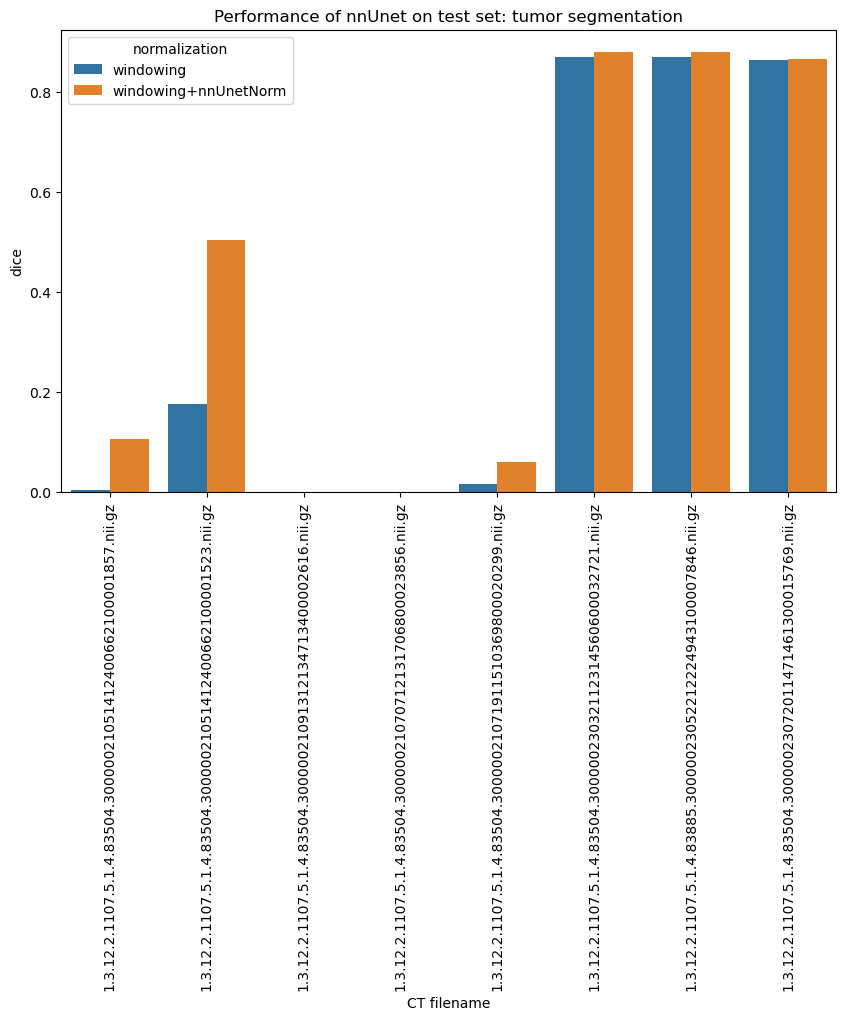

In [12]:
# Plot individual CT performance
new_df = test_results_df[test_results_df["label_name"] == 'tumor']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on test set: tumor segmentation")
if save_results:
    plt.savefig('performance_test_set_only_tumor.png', transparent=True, bbox_inches='tight')
plt.show()

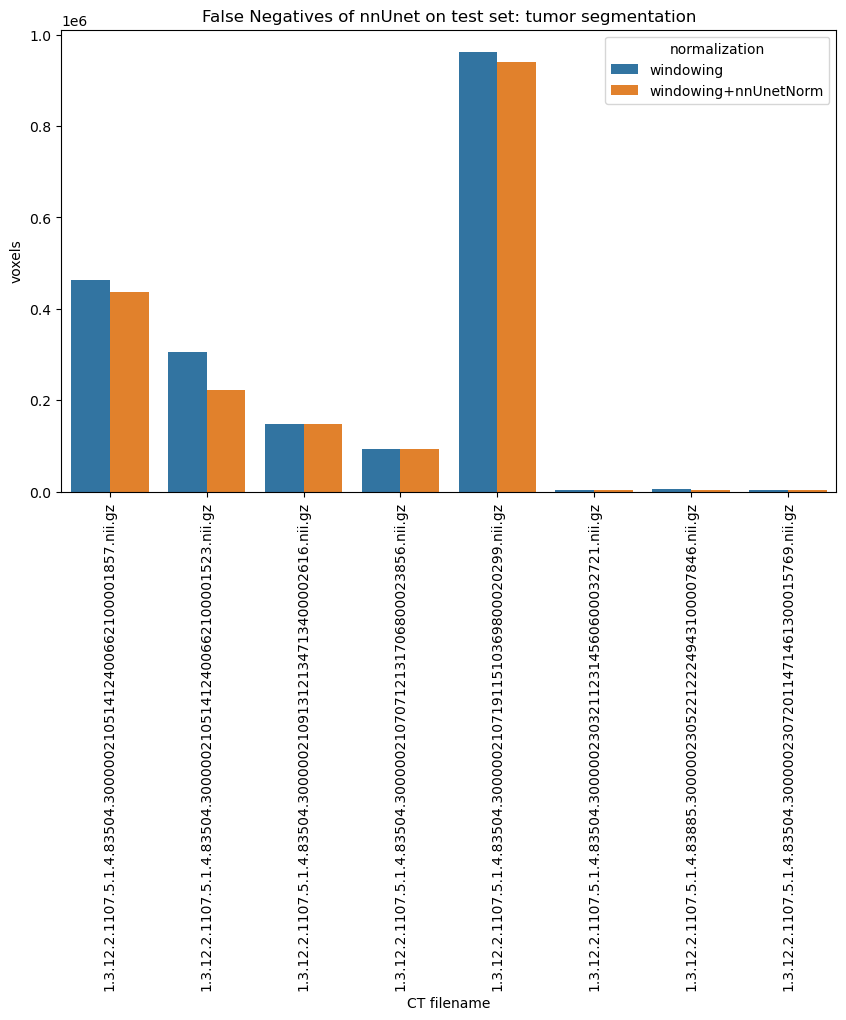

In [13]:
# Plot annotated voxels
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='FN',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.ylabel("voxels")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("False Negatives of nnUnet on test set: tumor segmentation")
plt.show()

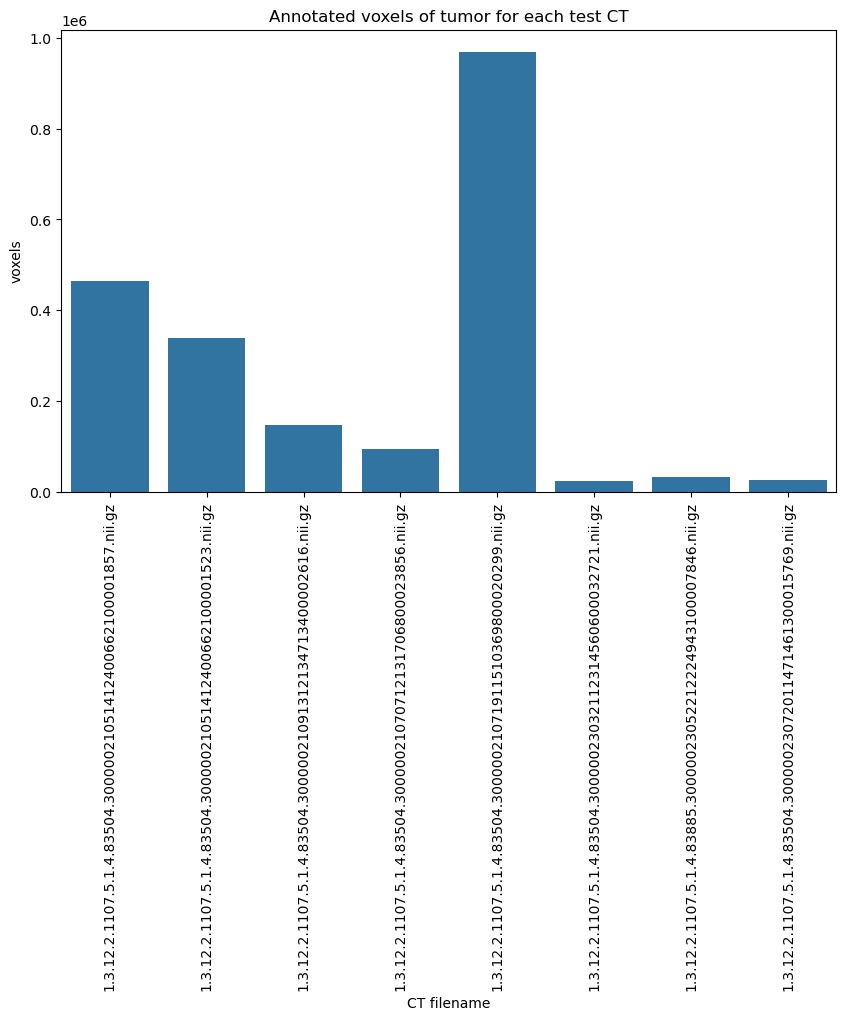

In [14]:
# Plot False Negatives
new_df = test_results_df[test_results_df["label_name"] == 'tumor']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='n_ref',
    color='tab:blue'
#    hue='normalization',
#    dodge=True
)
plt.xlabel("CT filename")
plt.ylabel("voxels")
plt.xticks(rotation=90, ha="center")
plt.title("Annotated voxels of tumor for each test CT")
if save_results:
    plt.savefig('annotated_voxels_only_tumor.png', bbox_inches='tight', transparent=True)
plt.show()

In [15]:
grouped = test_results_df.groupby(['label_name', 'normalization'])['dice'].agg(['mean', 'std']).reset_index()
display(grouped)

,label_name,normalization,mean,std
0,tumor,windowing,0.349139,0.432769
1,tumor,windowing+nnUnetNorm,0.411771,0.415611


## Desempeño agregado sobre todos los CTs de Test

In [16]:
aggregated_metrics_df = []
for normalization, class_name in itertools.product(
    test_results_df["normalization"].unique().tolist(),
    test_results_df["label_name"].unique().tolist()
):
    agg_metrics = get_aggregated_metrics(
        test_results_df[
            (test_results_df["normalization"] == normalization) &
            (test_results_df["label_name"] == class_name)
        ]
    )
    aggregated_metrics_df.append(
        {
            "normalization": normalization,
            "class_name": class_name,
            **agg_metrics
        }
    )
aggregated_metrics_df = pd.DataFrame(aggregated_metrics_df)
display(aggregated_metrics_df)

,normalization,class_name,TP,FP,FN,dice
0,windowing,tumor,110033,10265,1982617,0.099445
1,windowing+nnUnetNorm,tumor,240510,14316,1852140,0.204909


# Fine Tuning

In [34]:
paths_to_performances = {
    "hcuch": "resources/fine-tuning-nnunet/2d/performance_on_test_set_hcuch_model_516_ensemble.csv",
    "msd (liver+lung)": "resources/fine-tuning-nnunet/2d/performance_on_test_set_hcuch_model_520_foldall.csv",
    "finetuning": "resources/fine-tuning-nnunet/2d/performance_on_test_set_hcuch_model_531_fold0.csv"
}
paths_to_lesion_instances = {
    "train": "resources/lesion-instances/preprocessed_objects_results_train.csv",
    "test": "resources/lesion-instances/preprocessed_objects_results_test.csv"
}

In [35]:
# Aggregated performances
dfs = []
for key, path in paths_to_performances.items():
    df = pd.read_csv(path)
    df["model"] = key
    dfs.append(df)
agg_performance_df = pd.concat(dfs, ignore_index=True)

# Aggregated lesion instances
dfs = []
for key, path in paths_to_lesion_instances.items():
    df = pd.read_csv(path)
    df["subset"] = key
    dfs.append(df)
agg_lesion_instances_df = pd.concat(dfs, ignore_index=True)

## Performance

In [33]:
grouped = agg_performance_df.groupby('model')['dice'].agg(['mean', 'std']).reset_index()
display(grouped)

,model,mean,std
0,finetuning,0.496157,0.378145
1,hcuch,0.411771,0.415611
2,msd (liver+lung),0.523568,0.342514


In [28]:
agg_hcuch = get_aggregated_metrics(agg_df[agg_df['model'] == 'hcuch'])
for model in agg_df['model'].unique().tolist():
    agg_metrics = get_aggregated_metrics(agg_df[agg_df['model'] == model])
    print(f"model: {model}")
    print(agg_metrics)

model: hcuch
{'TP': 240510, 'FP': 14316, 'FN': 1852140, 'dice': 0.20490944316363618}
model: msd (liver+lung)
{'TP': 1058818, 'FP': 68845, 'FN': 1033832, 'dice': 0.657587010952041}
model: finetuning
{'TP': 521989, 'FP': 47224, 'FN': 1570661, 'dice': 0.3921982461155965}


## Lesion instances

In [70]:
agg_lesion_instances_df.columns

Index(['path_to_mask', 'filename', 'removed', 'label_value',
       'label_description', 'size_voxels', 'volume_ml',
       'axial_major_axis_length_mm', 'subset', 'tumor_type'],
      dtype='object')

In [76]:
agg_lesion_instances_df['tumor_type'] = agg_lesion_instances_df['label_description'].apply(lambda item: item.split(',')[0].strip())
# has_tumor train set
grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == 'train'].groupby('filename').apply(
    lambda group: True if any(item in group['tumor_type'].unique().tolist() for item in ['p', 'm']) else False,
    include_groups=False
).reset_index(name="has_tumor")
grouped.to_csv('has_tumor_train_set.csv', index=False)
train_filenames_with_tumors = grouped[grouped['has_tumor'] == True]['filename'].tolist()
print(f"train CTs with annotated tumors {len(train_filenames_with_tumors)}")
# has_tumor test set
grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == 'test'].groupby('filename').apply(
    lambda group: True if any(item in group['tumor_type'].unique().tolist() for item in ['p', 'm']) else False,
    include_groups=False
).reset_index(name="has_tumor")
grouped.to_csv('has_tumor_test_set.csv', index=False)
test_filenames_with_tumors = grouped[grouped['has_tumor'] == True]['filename'].tolist()
print(f"test CTs with annotated tumors: {len(test_filenames_with_tumors)}")
# Get CTs with m,higado
grouped_higado = agg_lesion_instances_df.groupby(['filename', 'subset']).apply(
    lambda group: True if 'm,higado' in group['label_description'].unique().tolist() else False,
    include_groups=False
).reset_index(name="has_m_higado")
grouped_pulmon = agg_lesion_instances_df.groupby(['filename', 'subset']).apply(
    lambda group: True if 'm,higado' in group['label_description'].unique().tolist() else False,
    include_groups=False
).reset_index(name="has_m_pulmon")
merged = grouped_higado.merge(
    grouped_pulmon,
    on=['filename', 'subset'],
    how='left'
)
display(merged)
merged.to_csv('tumor_types_for_each_ct.csv', index=False)

train CTs with annotated tumors 23
test CTs with annotated tumors: 8


,filename,subset,has_m_higado,has_m_pulmon
0,1.3.12.2.1107.5.1.4.83504.30000017121507082014...,test,False,False
1,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,train,False,False
2,1.3.12.2.1107.5.1.4.83504.30000019070312170000...,train,False,False
3,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,train,False,False
4,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,test,False,False
5,1.3.12.2.1107.5.1.4.83504.30000020021012090131...,test,False,False
6,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,test,False,False
7,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,train,False,False
8,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,train,True,True
9,1.3.12.2.1107.5.1.4.83504.30000020121611411612...,train,True,True


In [51]:
display(agg_lesion_instances_df)

,path_to_mask,filename,removed,label_value,label_description,size_voxels,volume_ml,axial_major_axis_length_mm,subset,tumor_type
0,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,False,1,"m,higado",650,0.803375,15.577010,train,m
1,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,False,2,"m,higado",1611,1.991135,17.883772,train,m
2,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,False,3,"m,pancreas",4139,5.115646,29.662908,train,m
3,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,False,4,"m,higado",2226,2.751251,24.999971,train,m
4,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,False,5,"m,higado",158,0.195282,18.607403,train,m
...,...,...,...,...,...,...,...,...,...,...
1025,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,False,10,"m,pulmon",1780,0.708411,12.659089,test,m
1026,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,False,11,"m,pulmon",2136,0.850093,14.729396,test,m
1027,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,False,12,"m,pulmon",1100,0.437782,11.932122,test,m
1028,/media/robber/Nuevo vol/medsam-finetuning-hcuc...,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,False,13,"m,pulmon",765,0.304457,9.520741,test,m


In [48]:
agg_lesion_instances_df['lesion_type'] = agg_lesion_instances_df['label_description'].unique()

array(['m,higado', 'm,pancreas', 'm,pulmon', 'n,pulmon', 'n,abdomen',
       'm,suprarrenal', 'n,axila', 'n,pelvis', 'm,bazo', 'm,ovario',
       'm,pared abdominal', 'm,costilla'], dtype=object)

In [37]:
agg_lesion_instances_df.columns

Index(['path_to_mask', 'filename', 'removed', 'label_value',
       'label_description', 'size_voxels', 'volume_ml',
       'axial_major_axis_length_mm', 'subset'],
      dtype='object')

In [40]:
test_grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == 'test'].groupby('filename').size().reset_index(name='lesions count')
display(test_grouped)
test_grouped.to_csv('lesions_count_test.csv', index=False)

,filename,lesions count
0,1.3.12.2.1107.5.1.4.83504.30000017121507082014...,3
1,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,3
2,1.3.12.2.1107.5.1.4.83504.30000020021012090131...,3
3,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,3
4,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,280
5,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,73
6,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,3
7,1.3.12.2.1107.5.1.4.83504.30000021070712131706...,7
8,1.3.12.2.1107.5.1.4.83504.30000021071911510369...,46
9,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,15


In [43]:
grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == 'test'].groupby('filename')['volume_ml'].sum().reset_index(name='total_annotated_volume_ml')
display(grouped)
grouped.to_csv('total_annotated_volume_ml_test.csv', index=False)

,filename,total_annotated_volume_ml
0,1.3.12.2.1107.5.1.4.83504.30000017121507082014...,1.047127
1,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,10.111139
2,1.3.12.2.1107.5.1.4.83504.30000020021012090131...,9.882235
3,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,6.681717
4,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,93.222368
5,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,435.567765
6,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,177.858992
7,1.3.12.2.1107.5.1.4.83504.30000021070712131706...,102.430603
8,1.3.12.2.1107.5.1.4.83504.30000021071911510369...,883.111591
9,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,143.737371


In [47]:
grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == "train"].groupby('filename').size().reset_index(name="lesions_count")
display(grouped)
test_grouped.to_csv('lesions_count_train.csv', index=False)

,filename,lesions_count
0,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,165
1,1.3.12.2.1107.5.1.4.83504.30000019070312170000...,92
2,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,94
3,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,2
4,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,8
5,1.3.12.2.1107.5.1.4.83504.30000020121611411612...,37
6,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,4
7,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,18
8,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,3
9,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,37


In [62]:
grouped = agg_lesion_instances_df[agg_lesion_instances_df['subset'] == 'train'].groupby('filename')['volume_ml'].sum().reset_index(name='total_annotated_volume_ml')
display(grouped)
grouped.to_csv('total_annotated_volume_ml_train.csv', index=False)

,filename,total_annotated_volume_ml
0,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,86.590816
1,1.3.12.2.1107.5.1.4.83504.30000019070312170000...,100.123901
2,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,81.372656
3,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,0.399188
4,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,146.553982
5,1.3.12.2.1107.5.1.4.83504.30000020121611411612...,239.003380
6,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,1.086446
7,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,160.530945
8,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,1.104543
9,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,186.836655
